# MSc Thesis - Hugo Stam

### Example 03 - Offshore Port System - Bridge

<img src="Figures/system_layout_alternative_3.2.png" style="width:1000px">

##### Investment Strategy Simulation - Adaptive terminal planning in the light of an uncertain future

* [**0. Prepare inputs:**](#0.-Prepare-inputs)<br>
   * [**0.1 Generate demand forecast scenario:**](#0.1-Generate-demand-forecast-scenario)<br>
   * [**0.2 Generate vessels:**](#0.2-Generate-vessels)<br>
* [**1. Instatiate system components:**](#1.-Instatiate-system-components)<br>
* [**2. Start simulation:**](#2.-Strart-simulation)<br>
* [**3. Report all elements:**](#3.-Report-all-elements)<br>

#### notes:


In [1]:
# packages for data handling
import numpy as np
import pandas as pd
import statistics as st

# packages related to time, space and id
import datetime, time
import platform
import random
from datetime import timedelta

# you need these dependencies packages related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# packages for figures
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
# sns.set(style="ticks")
# sns.set(style="darkgrid", palette = "pastel")
# sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# OpenTISim package
from opentisim import container_objects
from opentisim import container_defaults
from opentisim import container_system_offshore_bridge

# OpenCLSim package
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# Additional import to save the initialisation of the simulation
import openclsim.savesim as savesim

# Pretty-print a Python object to a stream
from pprint import pprint

# Jupyter Widgets
import ipywidgets as widgets

# 
from IPython.display import HTML

# Scroll to specific cell
from jupyter_helpers.utilities import scroll_to_current_cell

# 0. Prepare inputs

In [2]:
# iPython Widgests
annual_demand = widgets.IntSlider(
    value=1000000, min=500000, max=1500000, step=50000,
    description='Demand:', orientation='horizontal',
    readout=True, readout_format='d')

offshore_onshore_distance = widgets.IntSlider(
    value=40, min=20, max=60, step=20,
    description='Distance:', orientation='horizontal',
    readout=True, readout_format='d')

container_ship = widgets.Dropdown(
    options=[('Post Panamax I (6,000 TEU)', 6000), 
             ('New-Panamax (12,500 TEU)', 12500), 
             ('ULCS (21,000 TEU)', 21000)],
    value=12500, 
    description='OGV:')

truck = widgets.Dropdown(
    options=[('Small (2 TEU)', 2), 
             ('Medium (2.5 TEU)', 2.5), 
             ('Large (3 TEU)', 3)],
    value=2, 
    description='Truck:')

life_cycle = widgets.IntSlider(
    value=10, min=5, max=30, step=5,
    description='Life cycle:', orientation='horizontal',
    readout=True, readout_format='d')

print('Input Values')
display(annual_demand, offshore_onshore_distance, container_ship, truck, life_cycle)

Input Values


IntSlider(value=1000000, description='Demand:', max=1500000, min=500000, step=50000)

IntSlider(value=40, description='Distance:', max=60, min=20, step=20)

Dropdown(description='OGV:', index=1, options=(('Post Panamax I (6,000 TEU)', 6000), ('New-Panamax (12,500 TEU…

Dropdown(description='Truck:', options=(('Small (2 TEU)', 2), ('Medium (2.5 TEU)', 2.5), ('Large (3 TEU)', 3))…

IntSlider(value=10, description='Life cycle:', max=30, min=5, step=5)

In [3]:
offshore_distance = offshore_onshore_distance.value
demand = annual_demand.value
design_container_ship = container_ship.value
design_truck = truck.value
lifecycle = life_cycle.value

print('The offshore distance:', offshore_distance, 'km')
print('The annual demand:', demand, 'TEU')
print('The design container ship capacity:', design_container_ship, 'TEU')
print('The design barge capacity:', design_truck, 'TEU')
print('The design life cycle:', lifecycle, 'years')

avg_parcel = design_container_ship / 8

startyear = 2020

The offshore distance: 40 km
The annual demand: 1000000 TEU
The design container ship capacity: 12500 TEU
The design barge capacity: 2 TEU
The design life cycle: 10 years


## 0.1 Generate demand forecast scenario

In [4]:
# total_ocean_transport = 1000000  # TEU
# years = list(range(startyear, startyear+lifecycle))
# demand_list = []

# for year in years:
#     if year < 2025:
#         demand.append(total_ocean_transport)
#     elif year < 2030:
#         demand.append(total_ocean_transport * 1.5)
#     else:
#         demand.append(total_ocean_transport * 2.0)

# plt.plot(years, demand, 'o')
# plt.ylabel('Demand [TEU]')

In [5]:
years = list(range(startyear, startyear + lifecycle))
        
scenario_data={'year': years, 'volume': demand}

# instantiate Commodity objects, the inputs for the Commodity class
if design_container_ship == 6000:
    container_defaults.container_data['post_panamax_I_perc'] = 100
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 0

if design_container_ship == 12500:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 100
    container_defaults.container_data['ULCS_perc'] = 0
    
if design_container_ship == 21000:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 100
    
print(container_defaults.container_data)

# ladens
container = container_objects.Commodity(**container_defaults.container_data)
container.scenario_data = pd.DataFrame(data=scenario_data)
# print(container.scenario_data)

# combine
demand = [container]

{'name': 'Laden', 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0}


## 0.2 Generate vessels

In [6]:
# instantiate vessels
fully_cellular = container_objects.Vessel(**container_defaults.fully_cellular_data)
panamax = container_objects.Vessel(**container_defaults.panamax_data)
panamax_max = container_objects.Vessel(**container_defaults.panamax_max_data)
post_panamax_I = container_objects.Vessel(**container_defaults.post_panamax_I_data)
post_panamax_II = container_objects.Vessel(**container_defaults.post_panamax_II_data)
new_panamax = container_objects.Vessel(**container_defaults.new_panamax_data)
VLCS = container_objects.Vessel(**container_defaults.VLCS_data)
ULCS = container_objects.Vessel(**container_defaults.ULCS_data)

vessels = [fully_cellular, panamax, panamax_max, post_panamax_I, post_panamax_II, new_panamax, VLCS, ULCS] 

# 1. Instatiate system components

## 1.1 Terminal system

Specify the variables

In [7]:
OffshoreBridge = container_system_offshore_bridge.System(
                 startyear = startyear,
                 lifecycle = lifecycle,
                 stack_equipment='rs',
                 laden_stack='rs',
                 crane_type_defaults=container_defaults.sts_crane_data,
                 offshore_distance = offshore_distance,
                 allowable_berth_occupancy = 0.50,
                 transhipment_ratio = 0.0,
                 elements = demand + vessels,
                 laden_perc = 0.80, 
                 reefer_perc = 0.10, 
                 empty_perc = 0.05, 
                 oog_perc = 0.05,
                 operational_hours = 8640,     # 360 days 
                 debug=True)

# 2. Start simulation

This method automatically generates investment decisions, parametrically derived from demand trends and a number of investment triggers.

Apply frame of reference style decisions while stepping through each year of the terminal lifecycle and check if investment is needed (in light of strategic objective, operational objective, QSC, decision recipe, intervention method):
    1. for each year evaluate the demand of each commodity (see 0.1 Demand forecast scenario)
    2. for each year evaluate the various investment decisions
    3. for each year calculate the energy costs (requires insight in realized demands)
    4. for each year calculate the demurrage costs (requires insight in realized demands)
    5. for each year calculate terminal revenues
    6. collect all cash flows (capex, opex, revenues)
    7. calculate PV's and aggregate to NPV

In [8]:
OffshoreBridge.simulate()


Offshore Port System - Bridge Connection

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

  *** add Quay to elements
df    Year  Terminal Capex  Maintenance  Insurance
0  2020      24334677.0          0.0    

df    Year  Truck Capex  Truck Opex
0  2020      30000.0         0.0
1  2021          0.0      3000.0
2  2022          0.0      3000.0
3  2023          0.0      3000.0
4  2024          0.0      3000.0
truck_online 4
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020      40000.0         0.0
1  2021          0.0      4000.0
2  2022          0.0      4000.0
3  2023          0.0      4000.0
4  2024          0.0      4000.0
truck_online 5
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020      50000.0         0.0
1  2021          0.0      5000.0
2  2022          0.0      5000.0
3  2023          0.0      5000.0
4  2024          0.0      5000.0
truck_online 6
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020      60000.0         0.0
1  2021          0.0      6000.0
2  2022          0.0      6000.0
3  2023          0.0      6000.0
4  2024          0.0      6000.0
truck_online 7
  *** add Truck to elements
df    Year  Truck Capex 

c:\checkouts\opentisim\opentisim\container_system_offshore_bridge.py:1707: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system_offshore_bridge.py:2194: FutureWarning:

`item` has been deprecated and will be removed in a future version




truck_online 11
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     110000.0         0.0
1  2021          0.0     11000.0
2  2022          0.0     11000.0
3  2023          0.0     11000.0
4  2024          0.0     11000.0
truck_online 12
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     120000.0         0.0
1  2021          0.0     12000.0
2  2022          0.0     12000.0
3  2023          0.0     12000.0
4  2024          0.0     12000.0
truck_online 13
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     130000.0         0.0
1  2021          0.0     13000.0
2  2022          0.0     13000.0
3  2023          0.0     13000.0
4  2024          0.0     13000.0
truck_online 14
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     140000.0         0.0
1  2021          0.0     14000.0
2  2022          0.0     14000.0
3  2023          0.0     14000.0
4  2024          0.0     14000.0
truck_online 15
  *

4  2024          0.0     47000.0
truck_online 48
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     480000.0         0.0
1  2021          0.0     48000.0
2  2022          0.0     48000.0
3  2023          0.0     48000.0
4  2024          0.0     48000.0
truck_online 49
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     490000.0         0.0
1  2021          0.0     49000.0
2  2022          0.0     49000.0
3  2023          0.0     49000.0
4  2024          0.0     49000.0
truck_online 50
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     500000.0         0.0
1  2021          0.0     50000.0
2  2022          0.0     50000.0
3  2023          0.0     50000.0
4  2024          0.0     50000.0
truck_online 51
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     510000.0         0.0
1  2021          0.0     51000.0
2  2022          0.0     51000.0
3  2023          0.0     51000.0
4  2024          0.0

df    Year  Truck Capex  Truck Opex
0  2020     850000.0         0.0
1  2021          0.0     85000.0
2  2022          0.0     85000.0
3  2023          0.0     85000.0
4  2024          0.0     85000.0
truck_online 86
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     860000.0         0.0
1  2021          0.0     86000.0
2  2022          0.0     86000.0
3  2023          0.0     86000.0
4  2024          0.0     86000.0
truck_online 87
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     870000.0         0.0
1  2021          0.0     87000.0
2  2022          0.0     87000.0
3  2023          0.0     87000.0
4  2024          0.0     87000.0
truck_online 88
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     880000.0         0.0
1  2021          0.0     88000.0
2  2022          0.0     88000.0
3  2023          0.0     88000.0
4  2024          0.0     88000.0
truck_online 89
  *** add Truck to elements
df    Year  Truck Ca

df    Year  Truck Capex  Truck Opex
0  2020    1210000.0         0.0
1  2021          0.0    121000.0
2  2022          0.0    121000.0
3  2023          0.0    121000.0
4  2024          0.0    121000.0
truck_online 122
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1220000.0         0.0
1  2021          0.0    122000.0
2  2022          0.0    122000.0
3  2023          0.0    122000.0
4  2024          0.0    122000.0
truck_online 123
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1230000.0         0.0
1  2021          0.0    123000.0
2  2022          0.0    123000.0
3  2023          0.0    123000.0
4  2024          0.0    123000.0
truck_online 124
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1240000.0         0.0
1  2021          0.0    124000.0
2  2022          0.0    124000.0
3  2023          0.0    124000.0
4  2024          0.0    124000.0
truck_online 125
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    1580000.0         0.0
1  2021          0.0    158000.0
2  2022          0.0    158000.0
3  2023          0.0    158000.0
4  2024          0.0    158000.0
truck_online 159
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1590000.0         0.0
1  2021          0.0    159000.0
2  2022          0.0    159000.0
3  2023          0.0    159000.0
4  2024          0.0    159000.0
truck_online 160
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1600000.0         0.0
1  2021          0.0    160000.0
2  2022          0.0    160000.0
3  2023          0.0    160000.0
4  2024          0.0    160000.0
truck_online 161
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1610000.0         0.0
1  2021          0.0    161000.0
2  2022          0.0    161000.0
3  2023          0.0    161000.0
4  2024          0.0    161000.0
truck_online 162
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    1950000.0         0.0
1  2021          0.0    195000.0
2  2022          0.0    195000.0
3  2023          0.0    195000.0
4  2024          0.0    195000.0
truck_online 196
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1960000.0         0.0
1  2021          0.0    196000.0
2  2022          0.0    196000.0
3  2023          0.0    196000.0
4  2024          0.0    196000.0
truck_online 197
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1970000.0         0.0
1  2021          0.0    197000.0
2  2022          0.0    197000.0
3  2023          0.0    197000.0
4  2024          0.0    197000.0
truck_online 198
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1980000.0         0.0
1  2021          0.0    198000.0
2  2022          0.0    198000.0
3  2023          0.0    198000.0
4  2024          0.0    198000.0
truck_online 199
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    2300000.0         0.0
1  2021          0.0    230000.0
2  2022          0.0    230000.0
3  2023          0.0    230000.0
4  2024          0.0    230000.0
truck_online 231
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2310000.0         0.0
1  2021          0.0    231000.0
2  2022          0.0    231000.0
3  2023          0.0    231000.0
4  2024          0.0    231000.0
truck_online 232
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2320000.0         0.0
1  2021          0.0    232000.0
2  2022          0.0    232000.0
3  2023          0.0    232000.0
4  2024          0.0    232000.0
truck_online 233
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2330000.0         0.0
1  2021          0.0    233000.0
2  2022          0.0    233000.0
3  2023          0.0    233000.0
4  2024          0.0    233000.0
truck_online 234
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    2640000.0         0.0
1  2021          0.0    264000.0
2  2022          0.0    264000.0
3  2023          0.0    264000.0
4  2024          0.0    264000.0
truck_online 265
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2650000.0         0.0
1  2021          0.0    265000.0
2  2022          0.0    265000.0
3  2023          0.0    265000.0
4  2024          0.0    265000.0
truck_online 266
   > Quay capacity planned 1516320 TEU per year
   > Throughput online 1000000 TEU per year
     Horizontal Transport online (@ start of year): 0
     Number of STS cranes        (@ start of year): 0

     Stack Capacity planned  (@ start of year): 0
     Stack Capacity online   (@ start of year): 0
     Stack Capacity required (@ start of year): 12912
     Total Laden and Reefer Ground Slots required (@ start of year): 3228

  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0         

c:\checkouts\opentisim\opentisim\container_system_offshore_bridge.py:1755: FutureWarning:

`item` has been deprecated and will be removed in a future version



df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.84

df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Mai


Below, the various investment decisions are evaluated for the year 2028.

Simulate year: 2028
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 3 Berth is online; 3 total planned
     a total of 3 Quay is online; 3 total planned
     a total of 9 STS_crane is online; 9 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): 0.478
     Berth occupancy online  (@ start of year): 0.478
     Crane occupancy planned (@ start of year): 0.33
     Crane occupancy online  (@ start of year): 0.33

   > Quay capacity planned 1516320 TEU per year
   > Throughput online 1000000 TEU per year
     Trucks online           (@ start of year): 266
     Required nr of trucks   (@ start of year): 266

   > Quay capacity planned 1516320 TEU per year
   > Throughput online 1000000 TEU p

c:\checkouts\opentisim\opentisim\container_system_offshore_bridge.py:559: FutureWarning:

`item` has been deprecated and will be removed in a future version



## 3. Report all elements

In [9]:
if True: 
    for element in OffshoreBridge.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.


Laden

{'historic_data': [], 'scenario_data':    year   volume
0  2020  1000000
1  2021  1000000
2  2022  1000000
3  2023  1000000
4  2024  1000000
5  2025  1000000
6  2026  1000000
7  2027  1000000
8  2028  1000000
9  2029  1000000, 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0, 'name': 'Laden', 'id': '5b94be76-1749-11ea-bff9-04d3b0b539c4'}

Fully_Cellular_1

{'type': 'Fully_Cellular', 'starting_time': 0, 'call_size': 312.5, 'LOA': 215, 'draught': 10.0, 'beam': 20.0, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, 'transport_costs': 200, 'name': 'Fully_Cellular_1', 'id': '5b95cf1e-1749-11ea-9990-04d3b0b539c4'}

Panamax_1

{'type': 'Panamax', 'starting_time': 0, 'call_size': 425.0, 'LOA': 250, 'draught': 12.5, 'beam': 32.2, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, '

Truck

{'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': 108000.0, 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': 1080000, 'ownership': 'Port authority', 'delivery_time': 1, 'lifespan': 10, 'unit_rate': 10000, 'operations_perc': 0.1, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'year_purchase': [], 'year_online': 2021, 'name': 'Truck', 'id': '5c07f2e6-1749-11ea-90e4-04d3b0b539c4', 'df':    Year  Truck Capex  Truck Opex
0  2020    1080000.0         0.0
1  2021          0.0    108000.0
2  2022          0.0    108000.0
3  2023          0.0    108000.0
4  2024          0.0    108000.0
5  2025          0.0    108000.0
6  2026          0.0    108000.0
7  2027          0.0    108000.0
8  2028          0.0    10

{'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': 236000.0, 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': 2360000, 'ownership': 'Port authority', 'delivery_time': 1, 'lifespan': 10, 'unit_rate': 10000, 'operations_perc': 0.1, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'year_purchase': [], 'year_online': 2021, 'name': 'Truck', 'id': '5c74f8a4-1749-11ea-9011-04d3b0b539c4', 'df':    Year  Truck Capex  Truck Opex
0  2020    2360000.0         0.0
1  2021          0.0    236000.0
2  2022          0.0    236000.0
3  2023          0.0    236000.0
4  2024          0.0    236000.0
5  2025          0.0    236000.0
6  2026          0.0    236000.0
7  2027          0.0    236000.0
8  2028          0.0    236000.0



Tractor-trailer

{'triggers': [], 'labour': 166153.84615384616, 'maintenance': 8500.0, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': 86000, 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'tractor_trailer', 'ownership': 'Terminal operator', 'delivery_time': 0, 'lifespan': 10, 'unit_rate': 85000, 'mobilisation': 1000, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'crew': 1, 'salary': 30000, 'utilisation': 0.8, 'fuel_consumption': 2, 'productivity': 1, 'required': 5, 'non_essential_moves': 1.2, 'year_purchase': [], 'year_online': 2022, 'name': 'Tractor-trailer', 'id': '5d2a3b76-1749-11ea-aa2e-04d3b0b539c4', 'shift': 6.6461538461538465, 'df':    Year  Terminal Capex  Maintenance         Labour          Fuel
0  2020             0.0          0

In [10]:
# scroll_to_current_cell(preserve=True)

In [11]:
# OffshoreBridge.terminal_elements_plot()

In [12]:
# OffshoreBridge.terminal_capacity_plot()

In [13]:
# OffshoreBridge.terminal_land_use_plot()

In [14]:
# OffshoreBridge.storage_area_plot()

#### Add cash flow information for each of the terminal elements.

In [15]:
terminal_capex, terminal_opex, bridge_construction, bridge_maintenance_dredging, truck_capex, truck_opex, cash_flows, cash_flows_df, cash_flows_WACC_real_df, NPV = OffshoreBridge.net_present_value()

In [16]:
# OffshoreBridge.terminal_opex_plot(cash_flows_df)

In [17]:
# OffshoreBridge.total_opex_plot(cash_flows_df)

In [18]:
# print('\033[1mCash Flow Plot\033[0m')
# OffshoreBridge.cashflow_plot(cash_flows_df)

In [19]:
print('\033[1mFinancial Indication\033[0m')
# print('')
# print('Cash Flows: {}'.format(cash_flows))
print('')
print('NPV: ${}'.format(f'{round(NPV,-3):,}'))

terminal_opex_list = ['Maintenance','Insurance','Energy','Labour', 'Fuel']
cash_flows_WACC_real_df.style.hide_columns(terminal_opex_list).hide_index()

Financial Indication

NPV: $-1,233,855,000.0


Year,Terminal Capex,Terminal Opex,Demurrage,Truck Capex,Truck Opex,Capital Dredging,Maintenance Dredging,Bridge Construction,Bridge Maintenance,Total Cash Flow,Total Opex
2020,7.72258e+07,0,0,3.5245e+08,0,0,0,3e+07,0,-4.59676e+08,0
2021,2.64419e+08,0,0,0,3.10341e+07,0,0,3.5221e+07,0,-3.30674e+08,0
2022,0,0,0,0,2.73263e+07,0,0,2.32597e+07,0,-9.55747e+07,4.49887e+07
2023,0,0,0,0,2.40615e+07,0,0,0,6.82692e+06,-7.05021e+07,3.96137e+07
2024,0,0,0,0,2.11867e+07,0,0,0,6.01127e+06,-6.20788e+07,3.48808e+07
2025,0,0,0,0,1.86554e+07,0,0,0,5.29308e+06,-5.46619e+07,3.07134e+07
2026,0,0,0,0,1.64266e+07,0,0,0,4.66068e+06,-4.81312e+07,2.70439e+07
2027,0,0,0,0,1.4464e+07,0,0,0,4.10385e+06,-4.23807e+07,2.38129e+07
2028,0,0,0,0,1.27359e+07,0,0,0,3.61354e+06,-3.73173e+07,2.09678e+07
2029,0,0,0,0,1.12143e+07,0,0,0,3.18181e+06,-3.28588e+07,1.84627e+07


 Cash Flow Plot - Weighted average cost of capital 


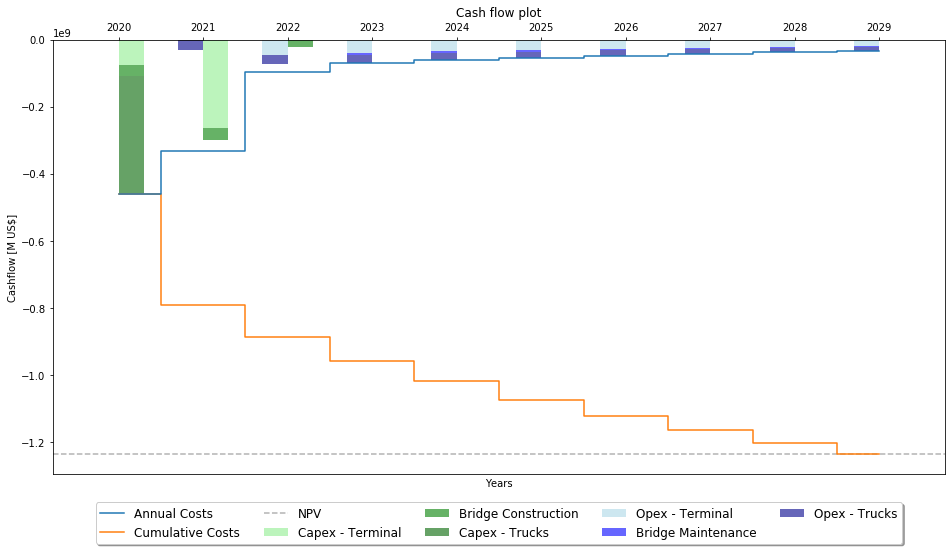

In [20]:
print('\033[1m Cash Flow Plot - Weighted average cost of capital \033[0m')
OffshoreBridge.cashflow_plot(cash_flows_WACC_real_df)